In [ ]:
!pip install requests --quiet

Data retrieval and procesing

In [100]:
import json
import requests
import pandas as pd

# ReliefWeb API endpoint
url = "https://api.reliefweb.int/v1/disasters"

# ICPAC countries
icpac_countries = [
    "Burundi", "Djibouti", "Eritrea", "Ethiopia", "Kenya", "Rwanda",
    "Somalia", "South Sudan", "Sudan", "Uganda", "Tanzania"
]

# Prepare the payload for the POST request
payload = {
    "filter": {"operator": "OR", "conditions": []},
    "fields": {"include": ["id", "name", "country", "date", "description", "type"]},
    "limit": 100,
    "sort": ["date:desc"]
}

# Add conditions for each country
for country in icpac_countries:
    payload["filter"]["conditions"].append({"field": "country.name", "value": country})

headers = {"Content-Type": "application/json", "Accept": "application/json"}

# POST request
response = requests.post(url, headers=headers, json=payload, timeout=60)

# Check response status
if response.status_code == 200:
    disaster_data = response.json()
    disasters = disaster_data.get("data", [])

    # Extract and process the data
    data_list = []
    for disaster in disasters:
        fields = disaster["fields"]
        description = fields.get("description", "Data not available")
        country_info = fields.get("country", [{"name": "N/A"}])[0]
        country_name = country_info.get("name", "N/A")
        # Extract coordinates from the country field
        coordinates = country_info.get("location", {}).get("geometry", {}).get("coordinates", [])
        latitude = coordinates[1] if len(coordinates) > 1 else "N/A"
        longitude = coordinates[0] if coordinates else "N/A"
        data = {
            "id": fields.get("id", "N/A"),
            "name": fields.get("name", "N/A"),
            "country": country_name,
            "date": fields.get("date", "N/A"),
            "description": description,
            "disaster_type": fields.get("type", "N/A"),
            "latitude": latitude,
            "longitude": longitude
        }
        data_list.append(data)

    # Convert to DataFrame
    df = pd.DataFrame(data_list)
    df.to_csv('disasters_data.csv', index=False)
else:
    print("Failed to retrieve data. Status code:", response.status_code)
    print("Response Content:", response.content)


In [102]:
import pandas as pd

# Load the data
df = pd.read_csv('disasters_data.csv')

# Function to extract event date from the nested dictionary
def extract_event_date(date_dict_str):
    try:
        date_dict = eval(date_dict_str)
        return date_dict.get('event', 'N/A')
    except (SyntaxError, ValueError):
        return 'N/A'

# Apply the function to extract event dates
df['event_date'] = df['date'].apply(extract_event_date)

# Convert event_date to datetime
df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['event_date'])

# Extract year, month, and day as features
df['year'] = df['event_date'].dt.year
df['month'] = df['event_date'].dt.month
df['day'] = df['event_date'].dt.day

# Drop the original date and description columns
df = df.drop(columns=['date', 'description', 'event_date'])

# Drop the country columns
country_columns = [col for col in df.columns if col.startswith('country_')]
df = df.drop(columns=country_columns)

# Drop the longitude and latitude columns
df = df.drop(columns=['longitude', 'latitude'])

# Save the processed data
df.to_csv('processed_disasters_data.csv', index=False)

print(df.head())


      id                         name                      country  \
0  52004  Ethiopia: Floods - May 2024                     Ethiopia   
1  52002    Uganda: Floods - May 2024                       Uganda   
2  51991    Rwanda: Floods - Apr 2024                       Rwanda   
3  51982  Tanzania: Floods - Apr 2024  United Republic of Tanzania   
4  51980   Somalia: Floods - Apr 2024                      Somalia   

                                       disaster_type  year  month  day  
0  [{'id': 4611, 'name': 'Flood', 'code': 'FL', '...  2024      5    8  
1  [{'id': 4611, 'name': 'Flood', 'code': 'FL', '...  2024      5    1  
2  [{'id': 4611, 'name': 'Flood', 'code': 'FL', '...  2024      4   20  
3  [{'id': 4611, 'name': 'Flood', 'code': 'FL', '...  2024      4    7  
4  [{'id': 4624, 'name': 'Flash Flood', 'code': '...  2024      4   19  


<Figure size 1200x800 with 0 Axes>

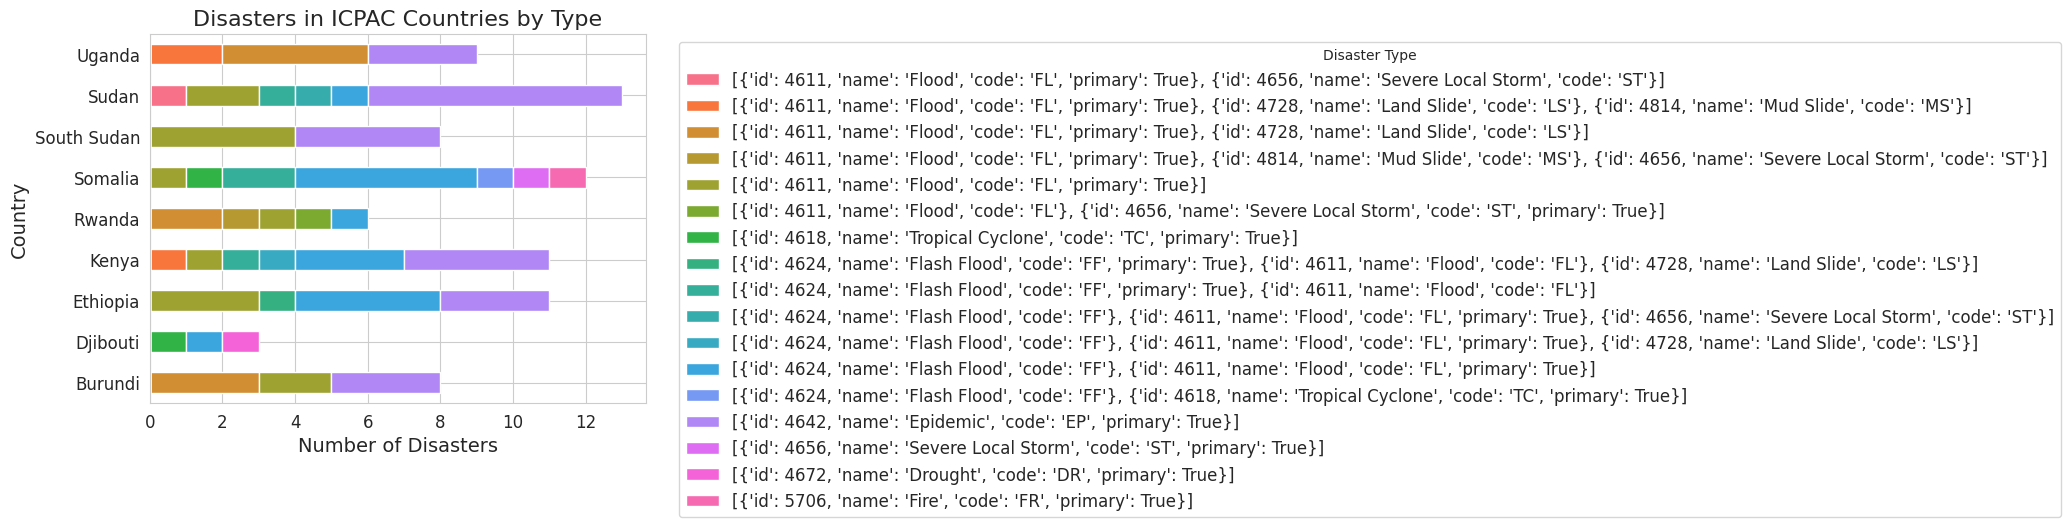

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Read the CSV file into a DataFrame
disasters_data = pd.read_csv('processed_disasters_data.csv')

# List of 11 countries in ICPAC
icpac_countries = ['Burundi', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya',
                   'Rwanda', 'Somalia', 'South Sudan', 'Sudan', 'Tanzania', 'Uganda']

# Filter data for only the 11 ICPAC countries
icpac_data = disasters_data[disasters_data['country'].isin(icpac_countries)]

# Grouping data by both country and disaster type
grouped_data = icpac_data.groupby(['country', 'disaster_type']).size().unstack(fill_value=0)

# Plotting disasters for each country in ICPAC by disaster type
plt.figure(figsize=(12, 8))
palette = sns.color_palette("husl", len(grouped_data.columns))
grouped_data.plot(kind='barh', stacked=True, color=palette)
plt.xlabel('Number of Disasters', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.title('Disasters in ICPAC Countries by Type', fontsize=16)
plt.legend(title='Disaster Type', fontsize=12, bbox_to_anchor=(1.05, 1))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


feature engineering

##MODEL TRAINING

In [116]:
# Print a sample of the "disaster_type" column
print(df['disaster_type'].head())


0    [{'id': 4611, 'name': 'Flood', 'code': 'FL', '...
1    [{'id': 4611, 'name': 'Flood', 'code': 'FL', '...
2    [{'id': 4611, 'name': 'Flood', 'code': 'FL', '...
3    [{'id': 4611, 'name': 'Flood', 'code': 'FL', '...
4    [{'id': 4624, 'name': 'Flash Flood', 'code': '...
Name: disaster_type, dtype: object


In [154]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Accuracy: 0.35294117647058826

Classification Report:
                                                                                                                                                                            precision    recall  f1-score   support

                                                         [{'id': 4611, 'name': 'Flood', 'code': 'FL', 'primary': True}, {'id': 4728, 'name': 'Land Slide', 'code': 'LS'}]       0.00      0.00      0.00         1
[{'id': 4611, 'name': 'Flood', 'code': 'FL', 'primary': True}, {'id': 4814, 'name': 'Mud Slide', 'code': 'MS'}, {'id': 4656, 'name': 'Severe Local Storm', 'code': 'ST'}]       0.00      0.00      0.00         1
                                                                                                           [{'id': 4611, 'name': 'Flood', 'code': 'FL', 'primary': True}]       0.50      0.33      0.40      

Model Testing and Evaluation

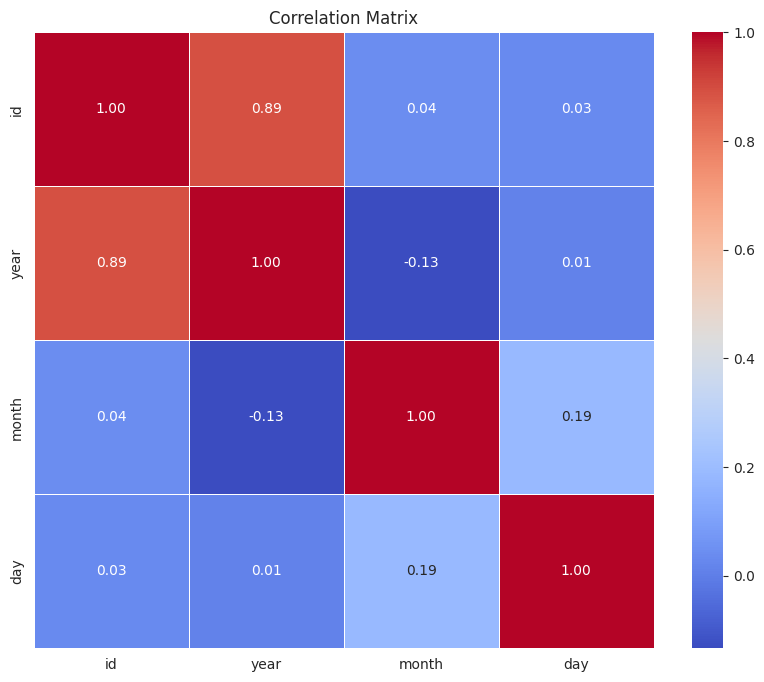

In [143]:
# Select only numeric columns
numeric_cols = icpac_data.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


Save the Model for Deployment

In [155]:
from joblib import dump

# Save the trained model
model_filename = 'random_forest_model.joblib'
dump(rf_classifier, model_filename)

print("Model saved successfully as", model_filename)


Model saved successfully as random_forest_model.joblib


In [156]:
from joblib import load

# Load the saved model
loaded_model = load(model_filename)

In [149]:
pip install fastapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [151]:
pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 6.6 MB/s eta 0:00:00
